In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
welding_data = pd.read_excel("./data/Welding Data Set_01.xlsx", index_col ="idx")

In [3]:
welding_data.head()

,Machine_Name,Item No,working time,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
idx,,,,,,,,,
1,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.33,14.57,2.701,72.0
2,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.36,14.57,2.701,72.0
3,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.37,14.54,2.703,71.0
4,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.37,14.54,2.703,72.0
5,Spot-01,65235-25800,2020-03-24,0.7,0.7,2.36,14.56,2.704,72.0


## 데이터 특성 파악

In [4]:
welding_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11939 entries, 1 to 669
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Machine_Name      11939 non-null  object        
 1   Item No           11939 non-null  object        
 2   working time      11939 non-null  datetime64[ns]
 3   Thickness 1(mm)   11939 non-null  float64       
 4   Thickness 2(mm)   11939 non-null  float64       
 5   weld force(bar)   11939 non-null  float64       
 6   weld current(kA)  11939 non-null  float64       
 7   weld Voltage(v)   11939 non-null  float64       
 8   weld time(ms)     11939 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 932.7+ KB


In [5]:
welding_data.describe()

,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
count,11939.0,11939.0,11939.000000,11939.000000,11939.000000,11939.000000
mean,0.7,0.7,2.787925,14.711208,2.704223,71.724123
std,0.0,0.0,1.455966,0.099000,0.024700,0.632049
min,0.7,0.7,1.740000,14.520000,2.464000,70.000000
25%,0.7,0.7,2.310000,14.610000,2.699000,71.000000
50%,0.7,0.7,2.340000,14.730000,2.702000,72.000000
75%,0.7,0.7,2.370000,14.750000,2.706000,72.000000
max,0.7,0.7,10.540000,15.070000,2.861000,73.000000


In [6]:
welding_data.corr()
# 0.1~0.3 : 약한 선형관계
# 0.3~0.7 : 뚜렷한 선형관계
# 0.7~    : 강한 상관관계

,Thickness 1(mm),Thickness 2(mm),weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
Thickness 1(mm),NaN,NaN,NaN,NaN,NaN,NaN
Thickness 2(mm),NaN,NaN,NaN,NaN,NaN,NaN
weld force(bar),NaN,NaN,1.000000,0.411675,0.133876,-0.005557
weld current(kA),NaN,NaN,0.411675,1.000000,0.129596,-0.020933
weld Voltage(v),NaN,NaN,0.133876,0.129596,1.000000,0.010169
weld time(ms),NaN,NaN,-0.005557,-0.020933,0.010169,1.000000


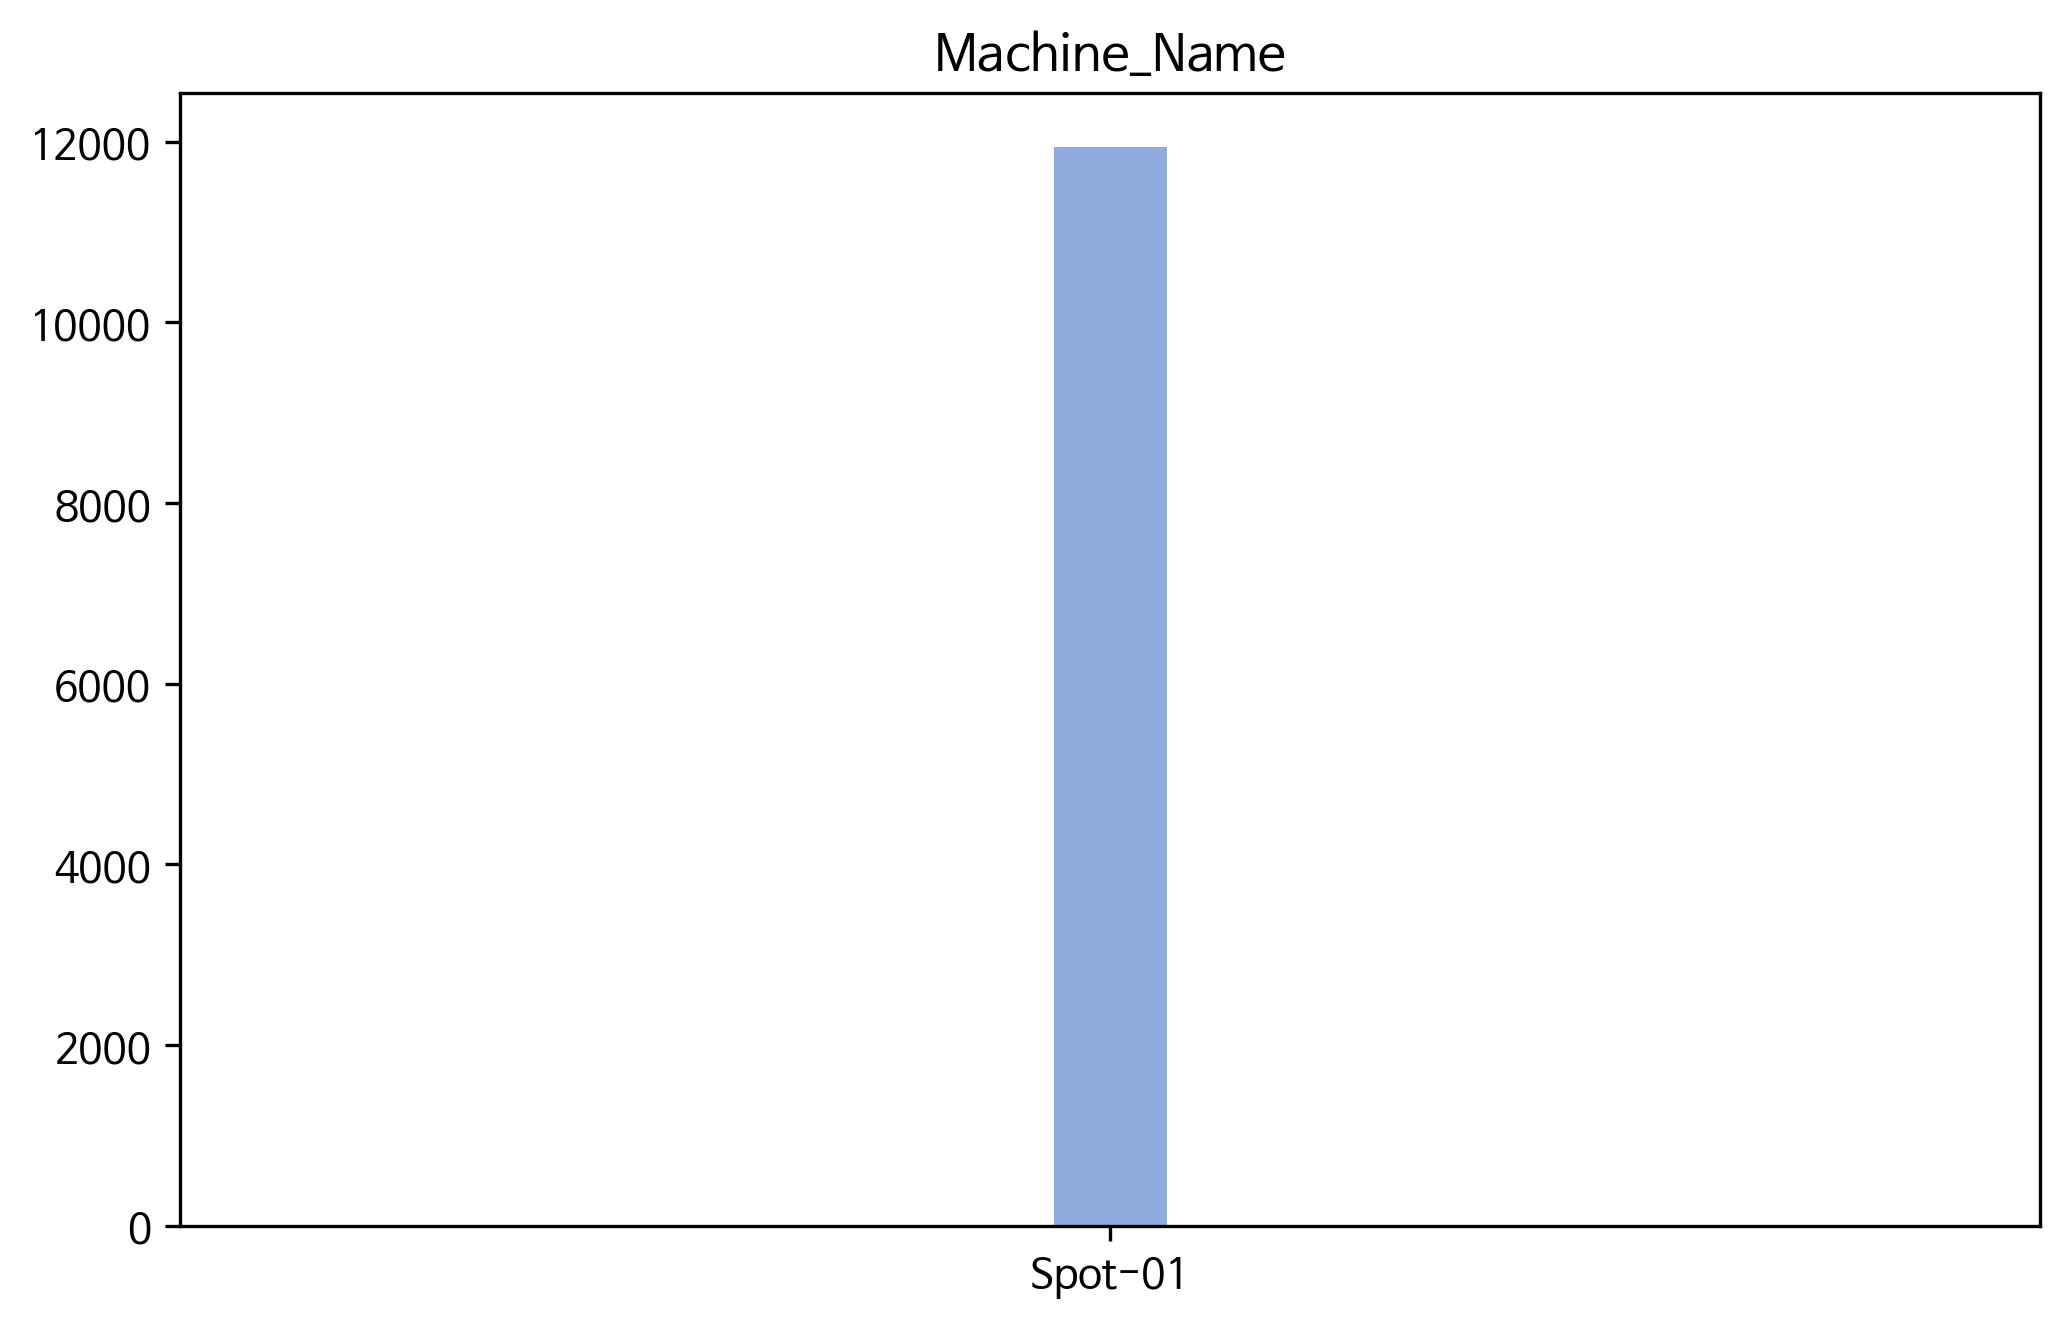

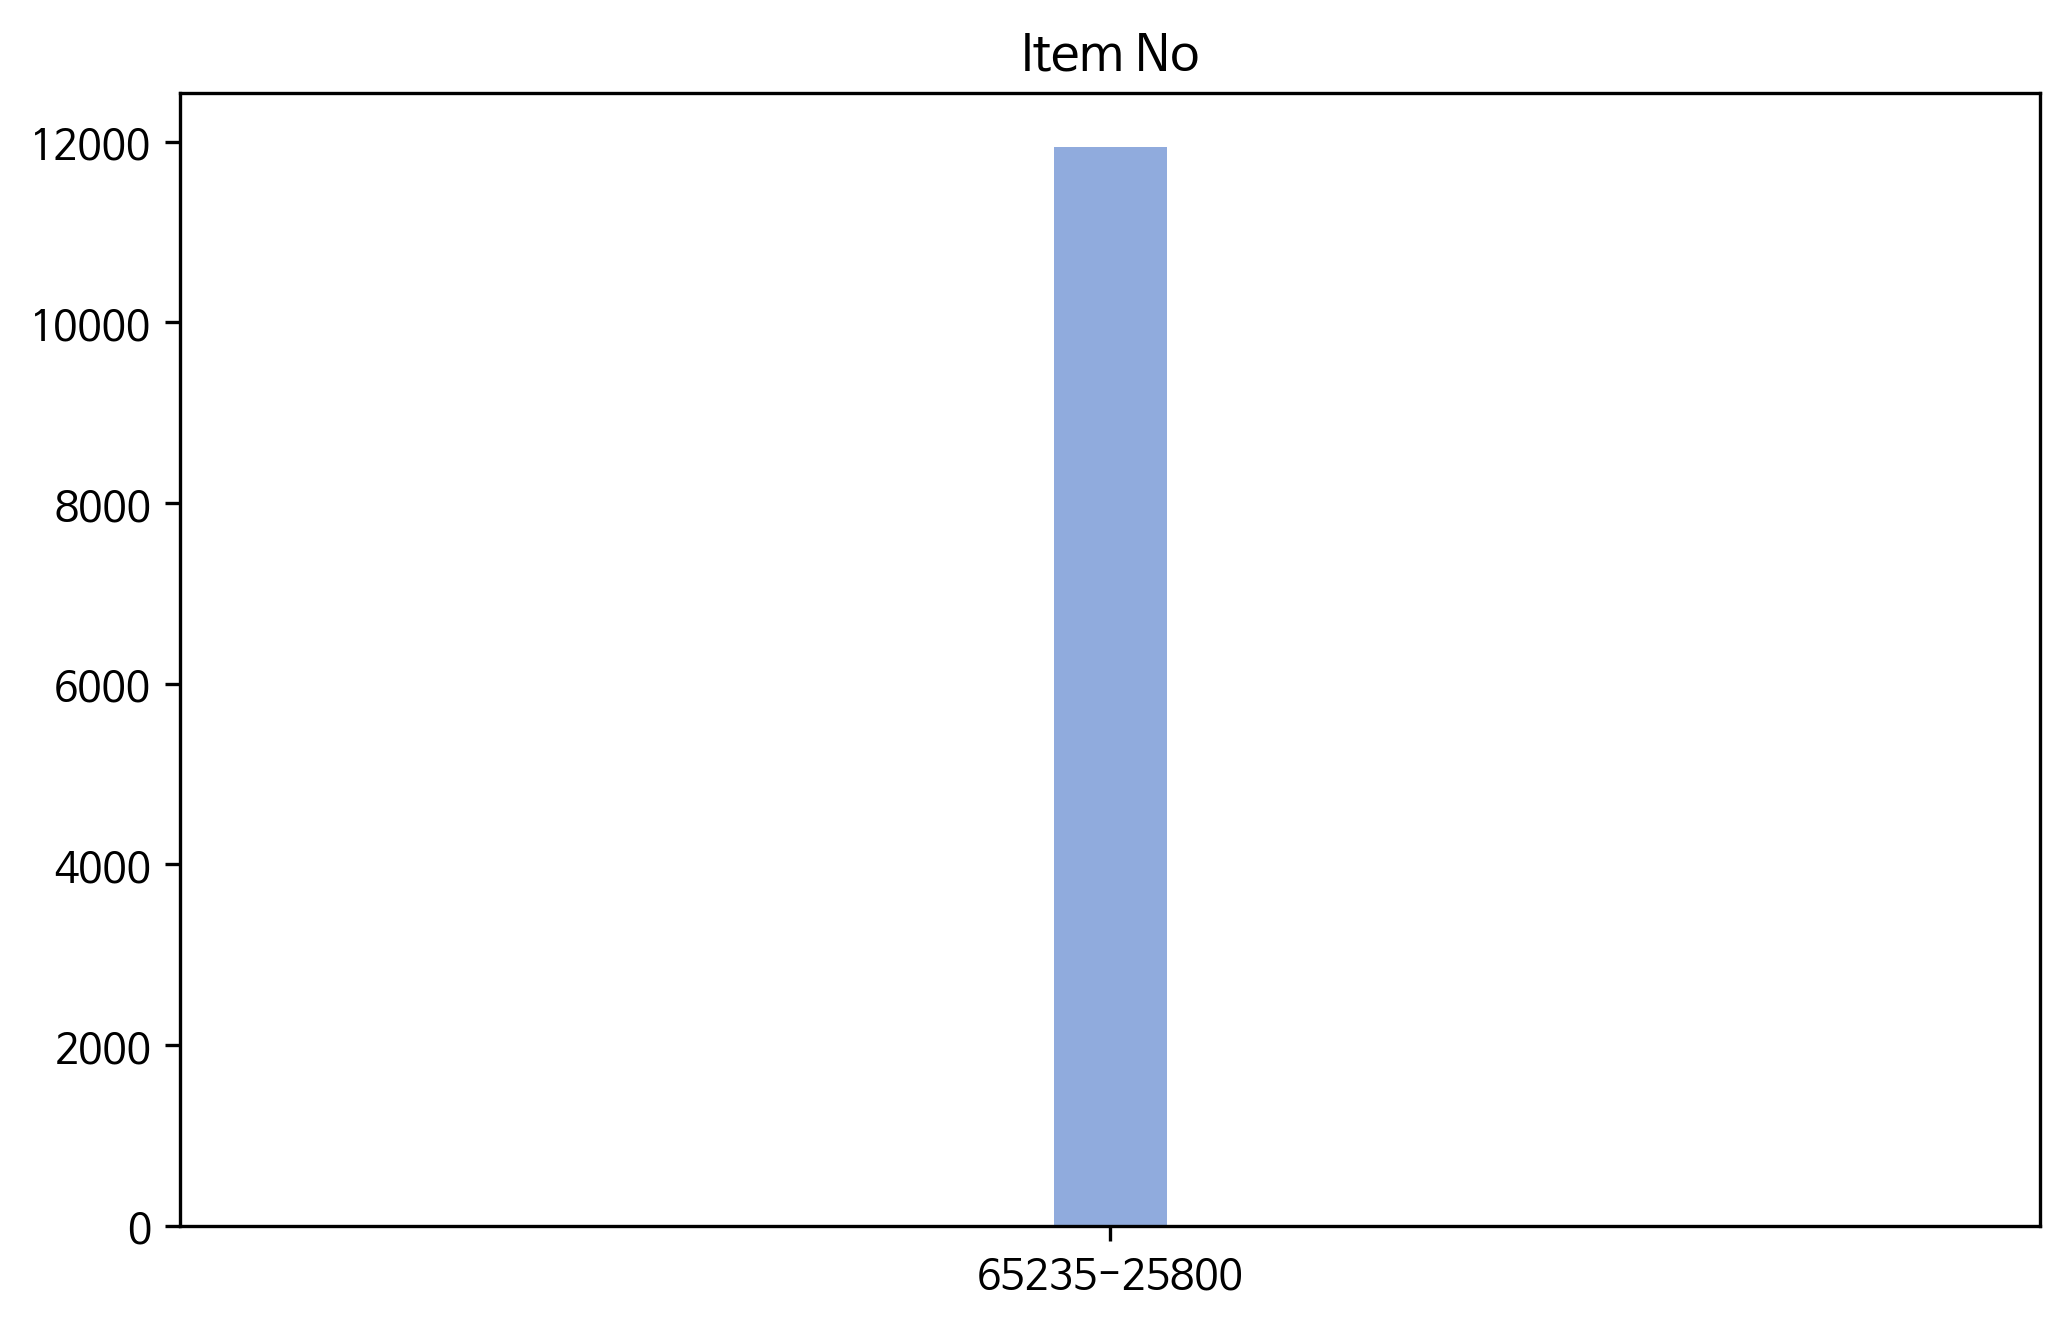

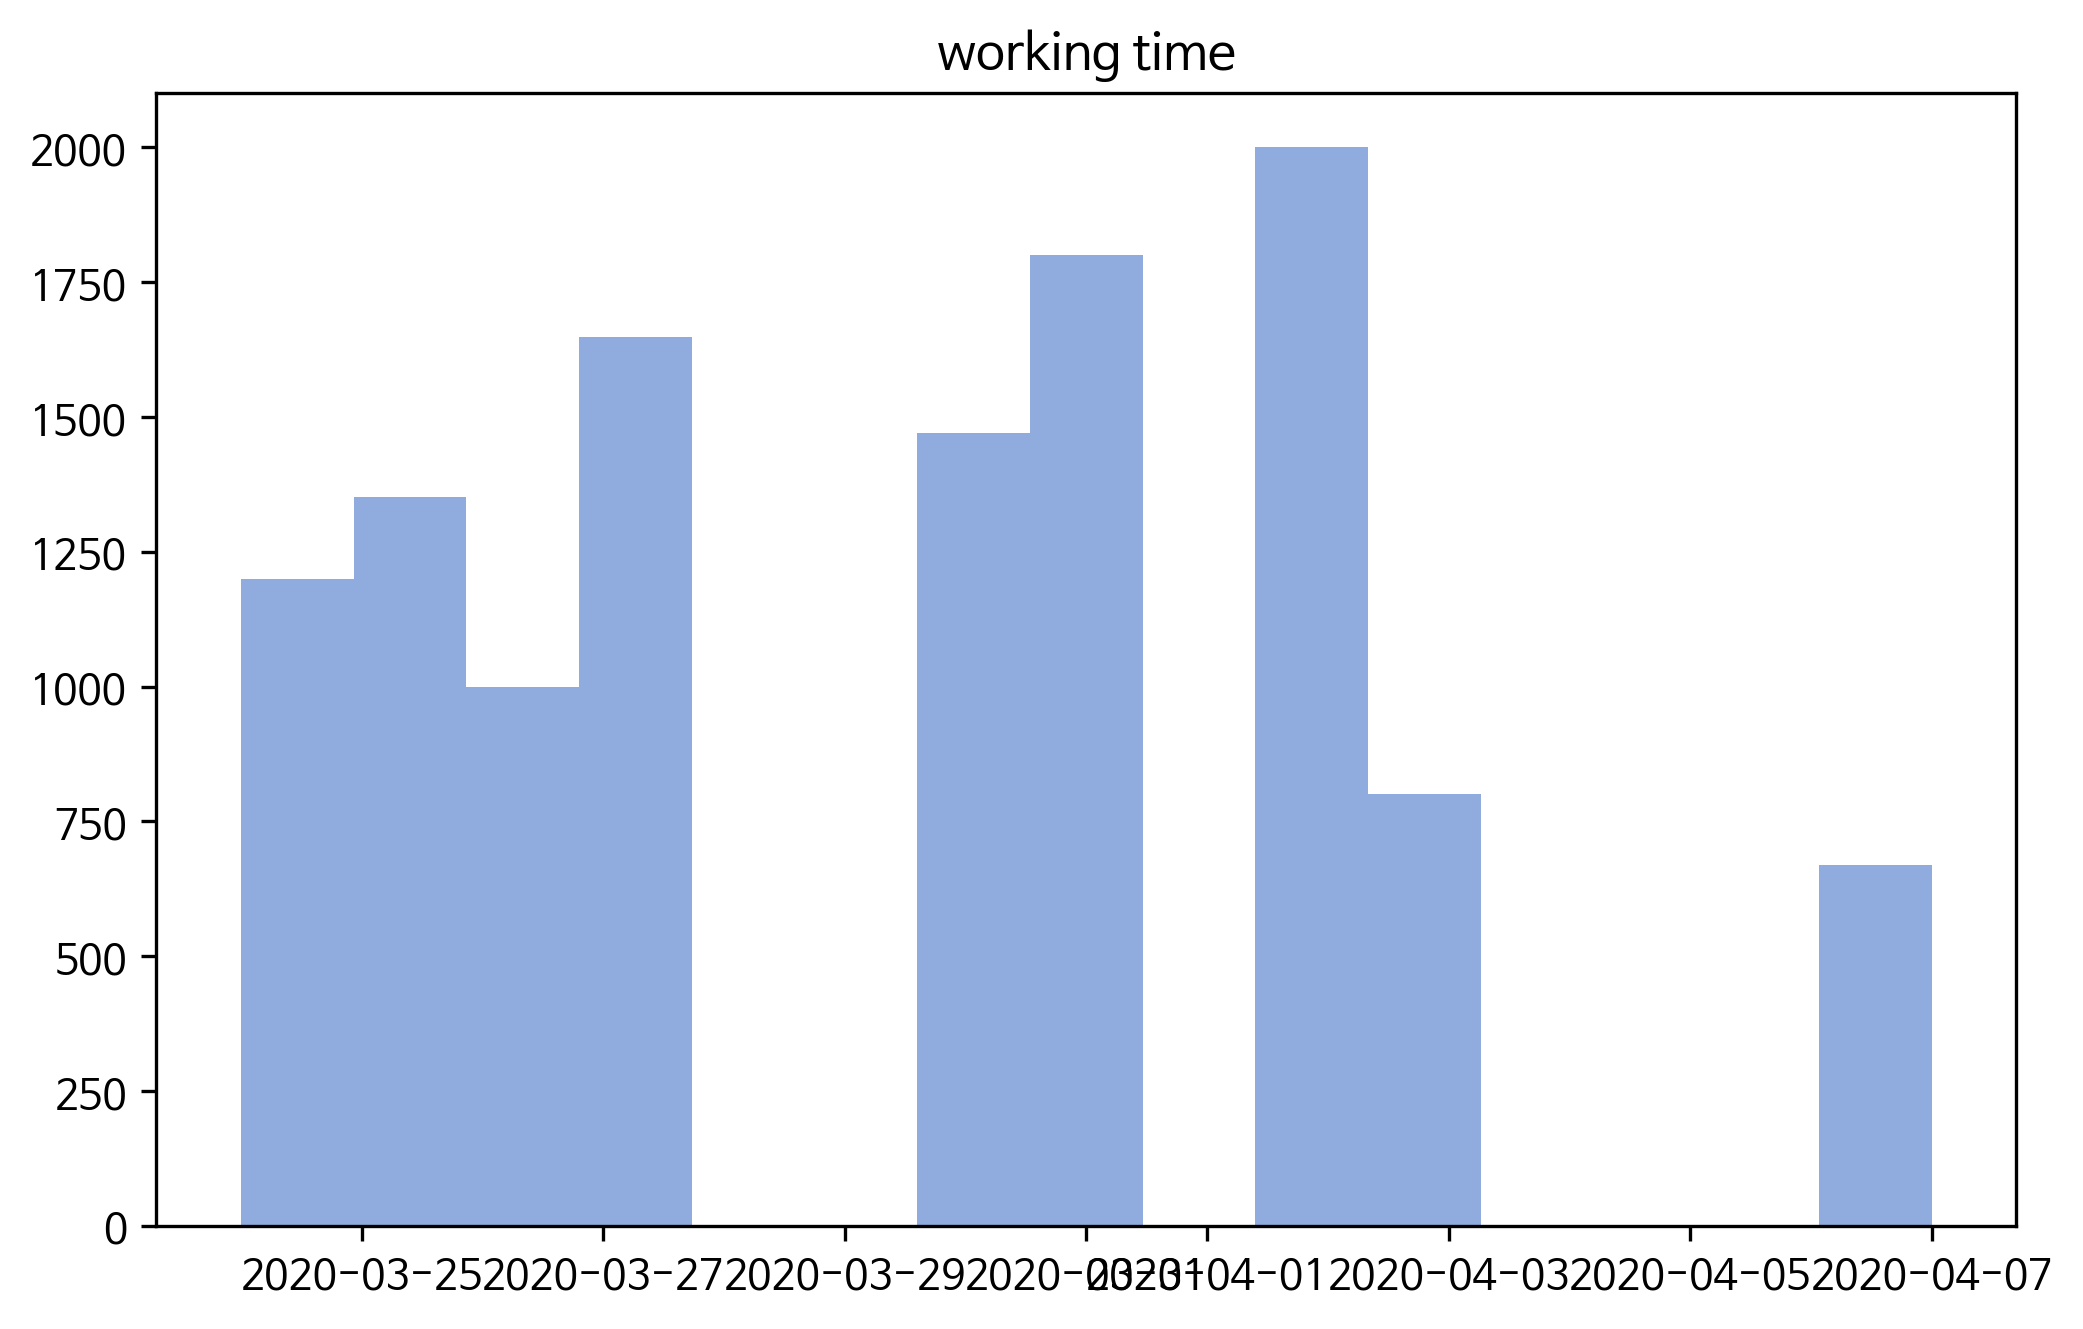

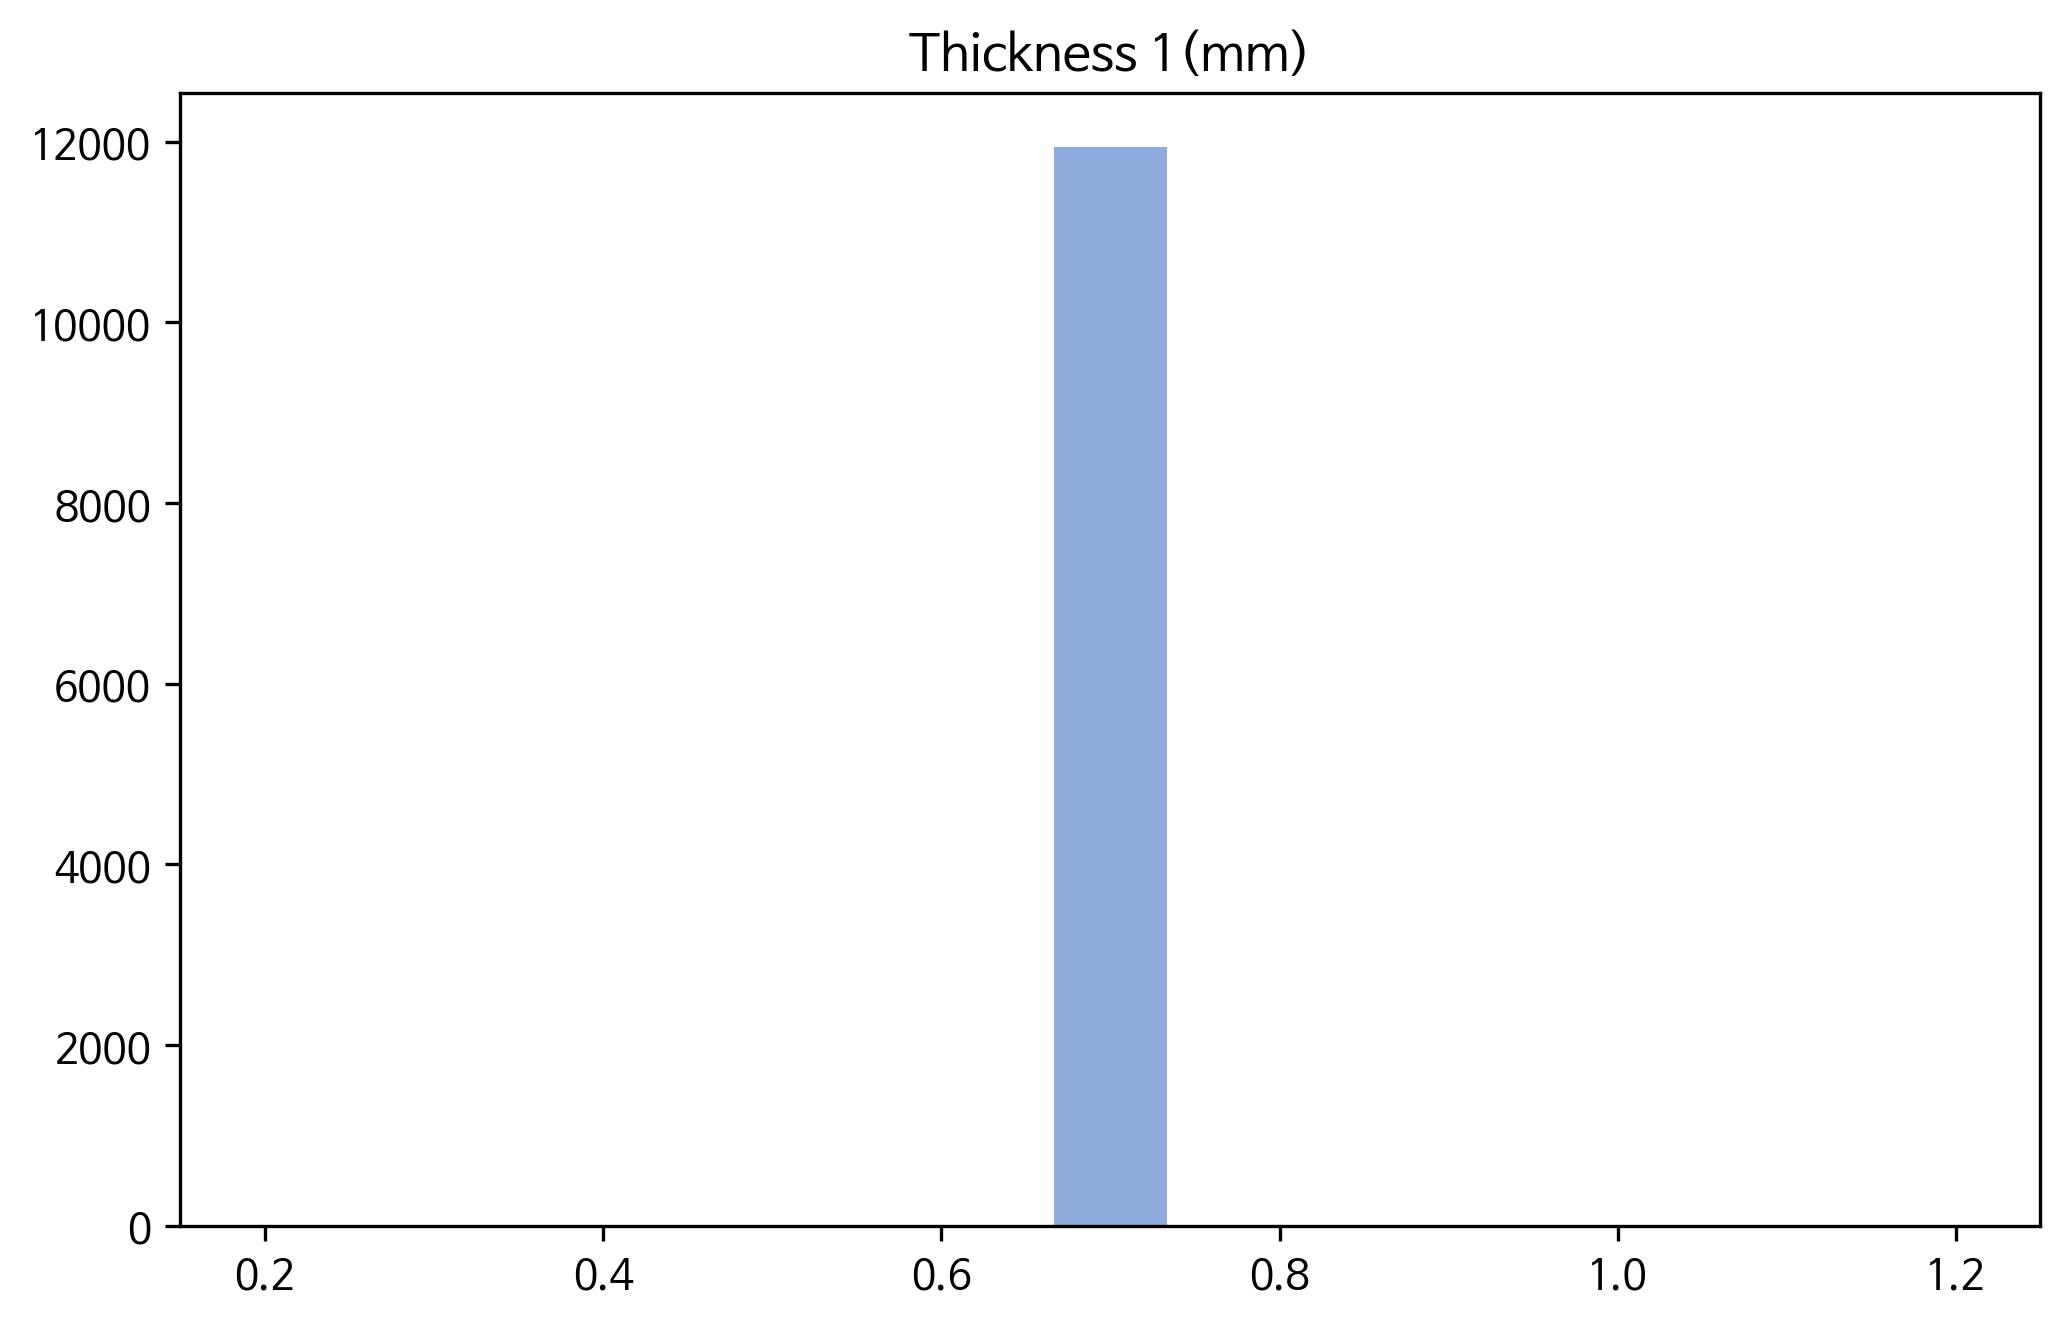

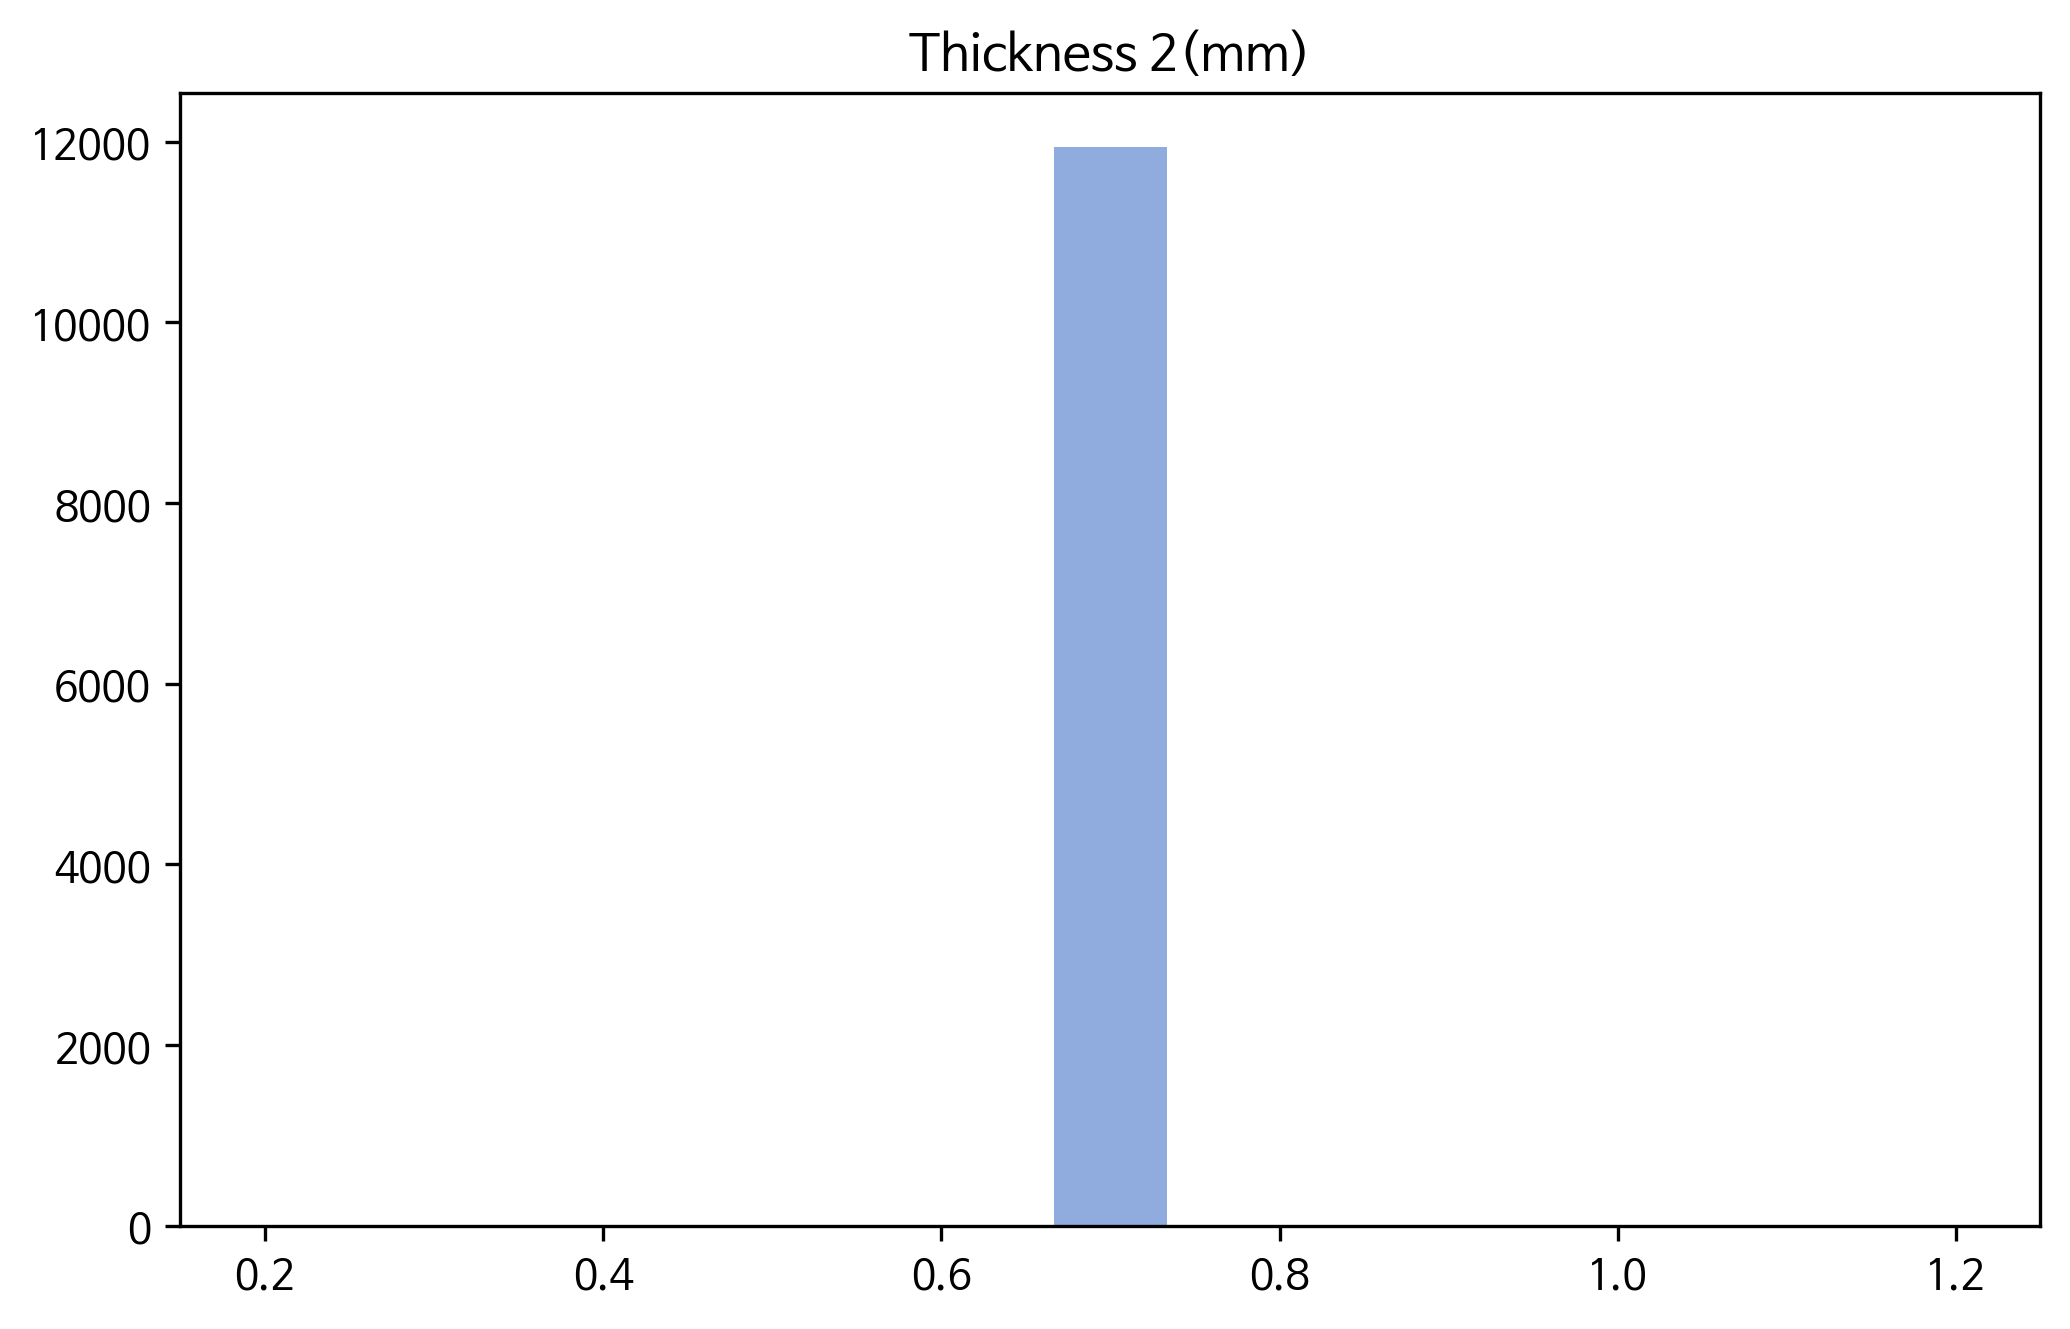

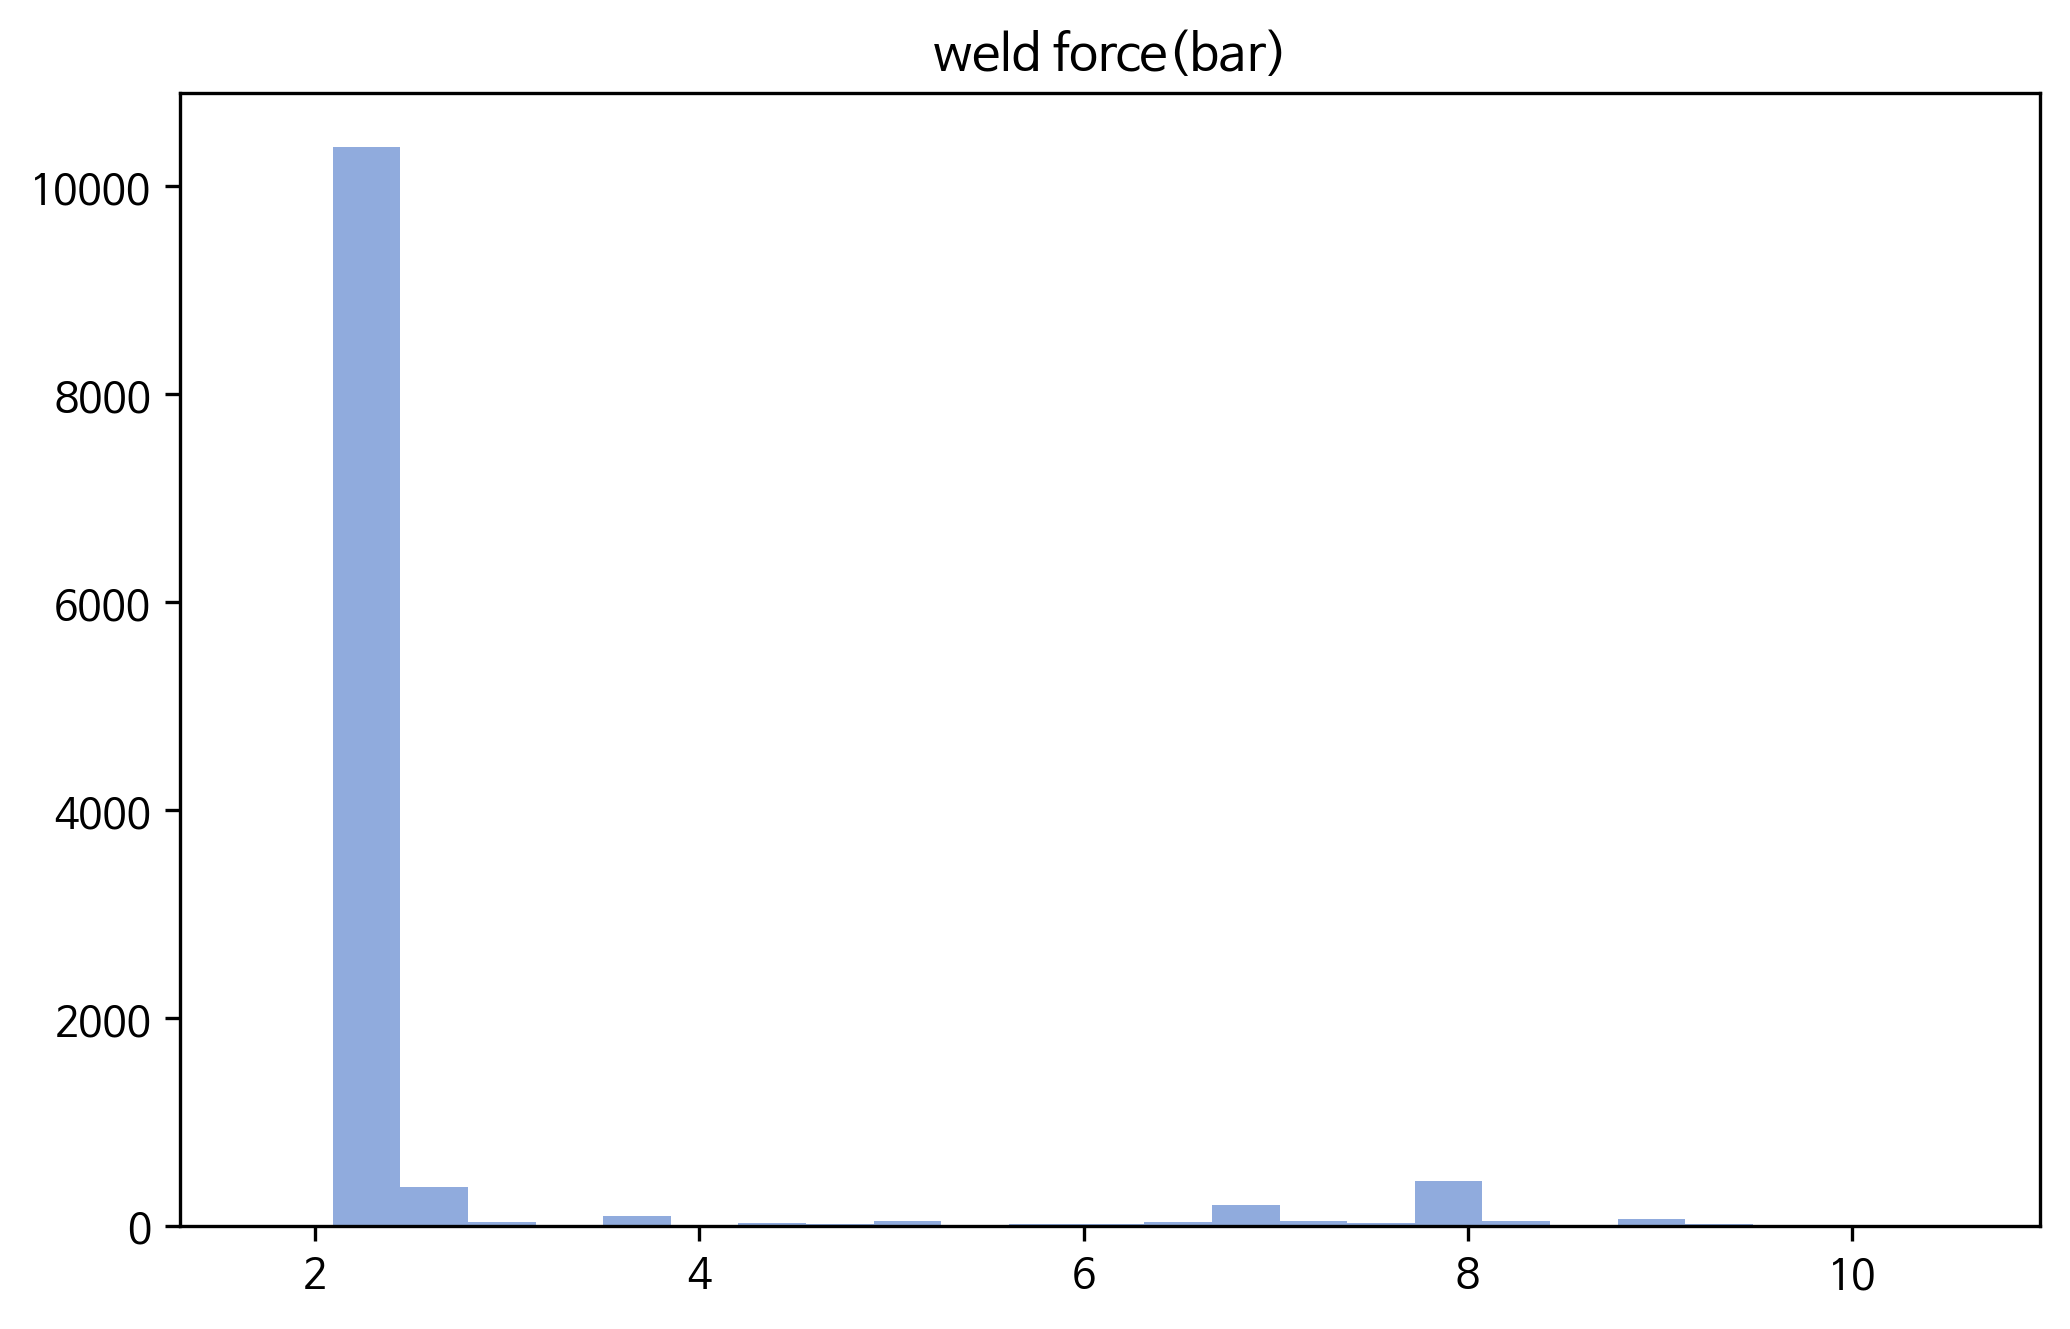

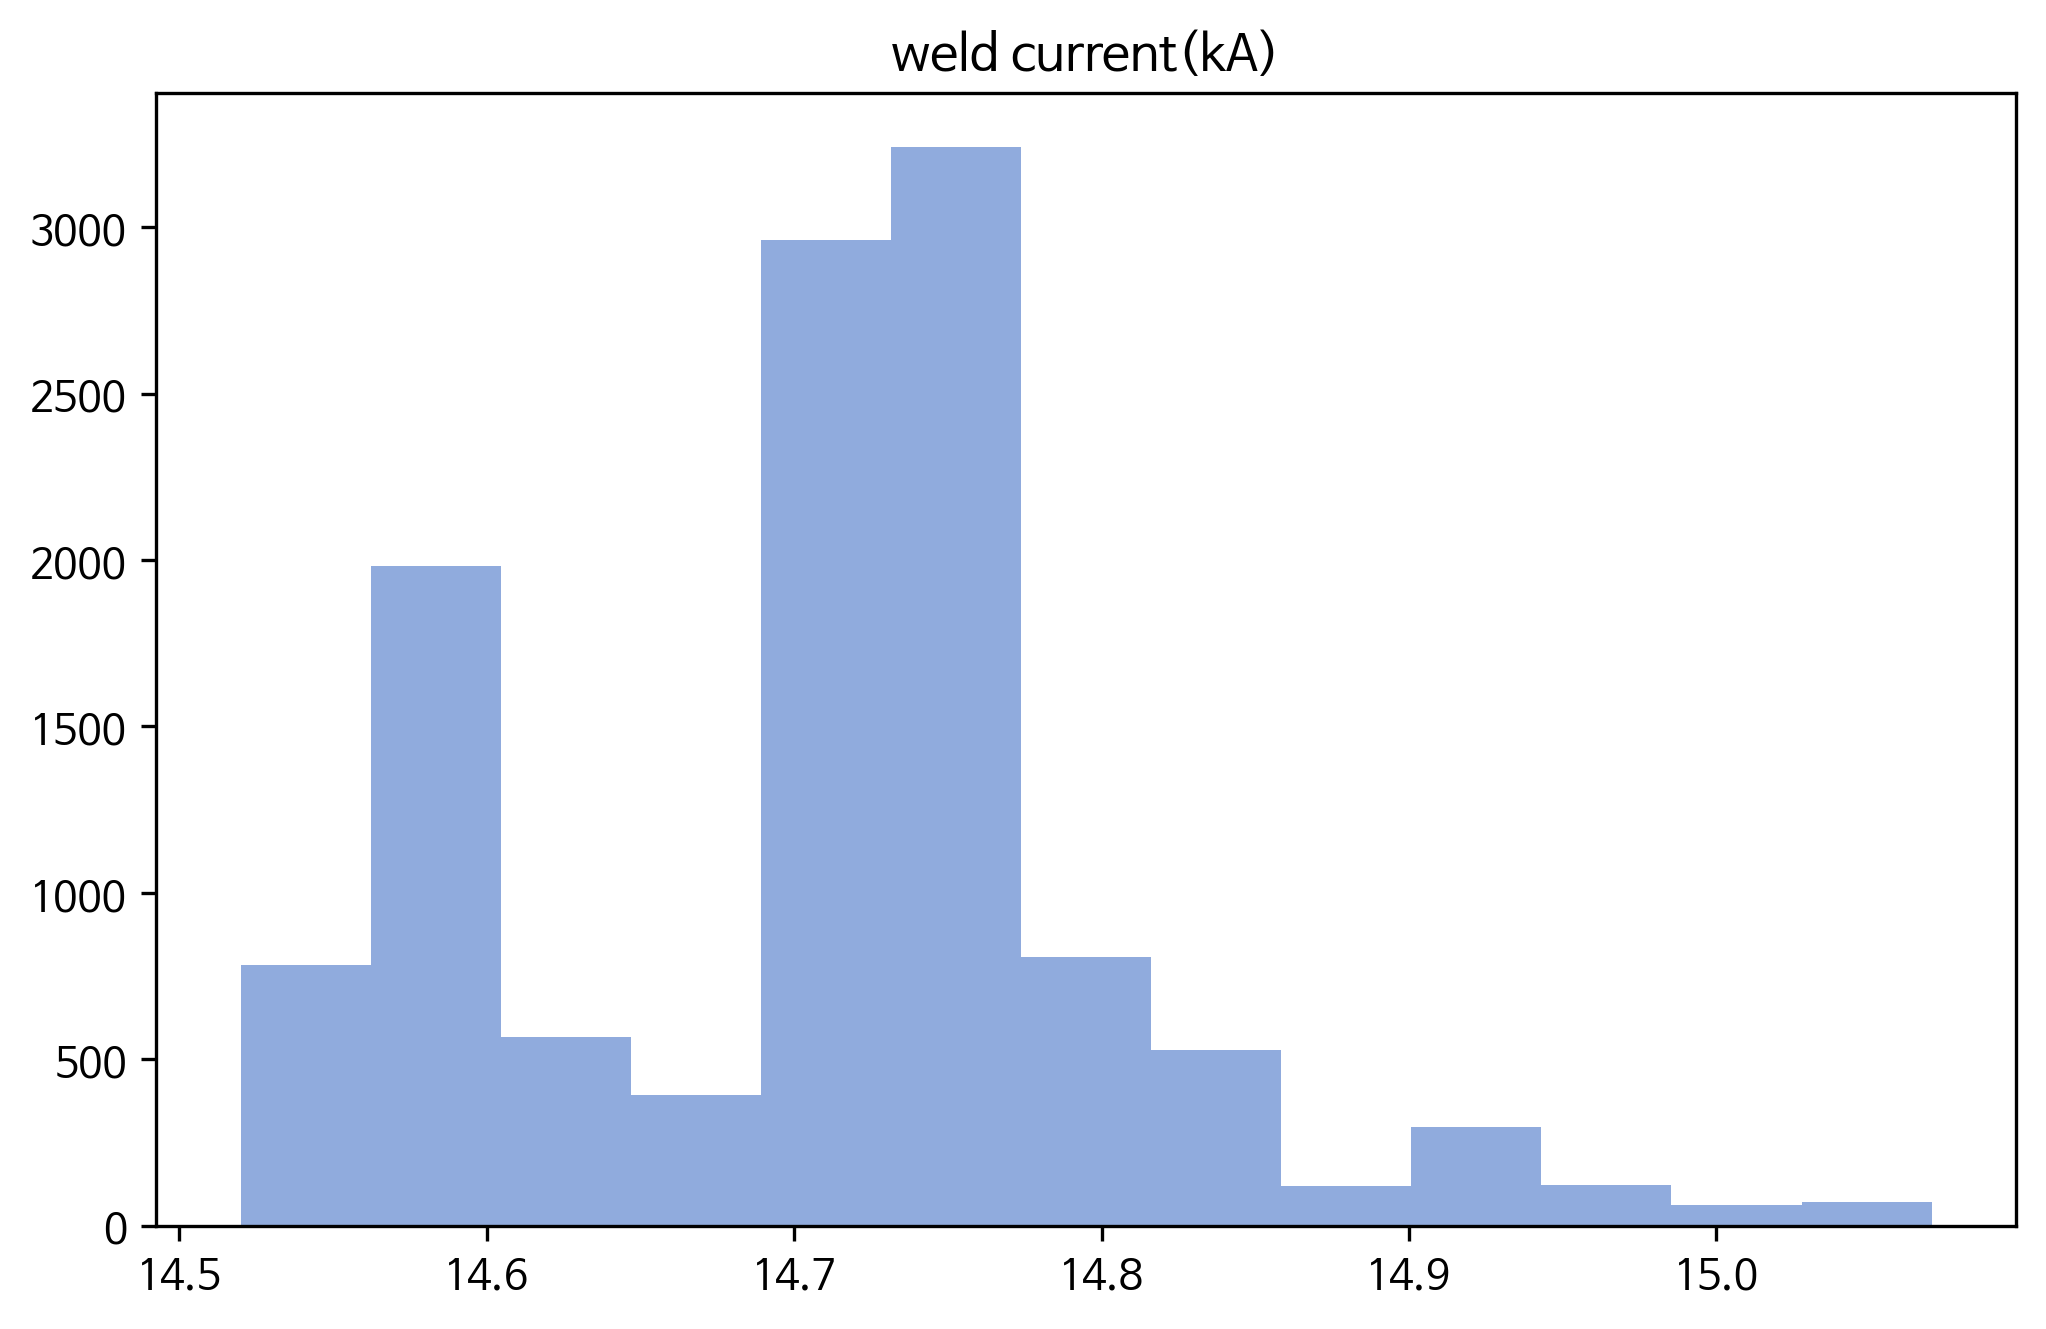

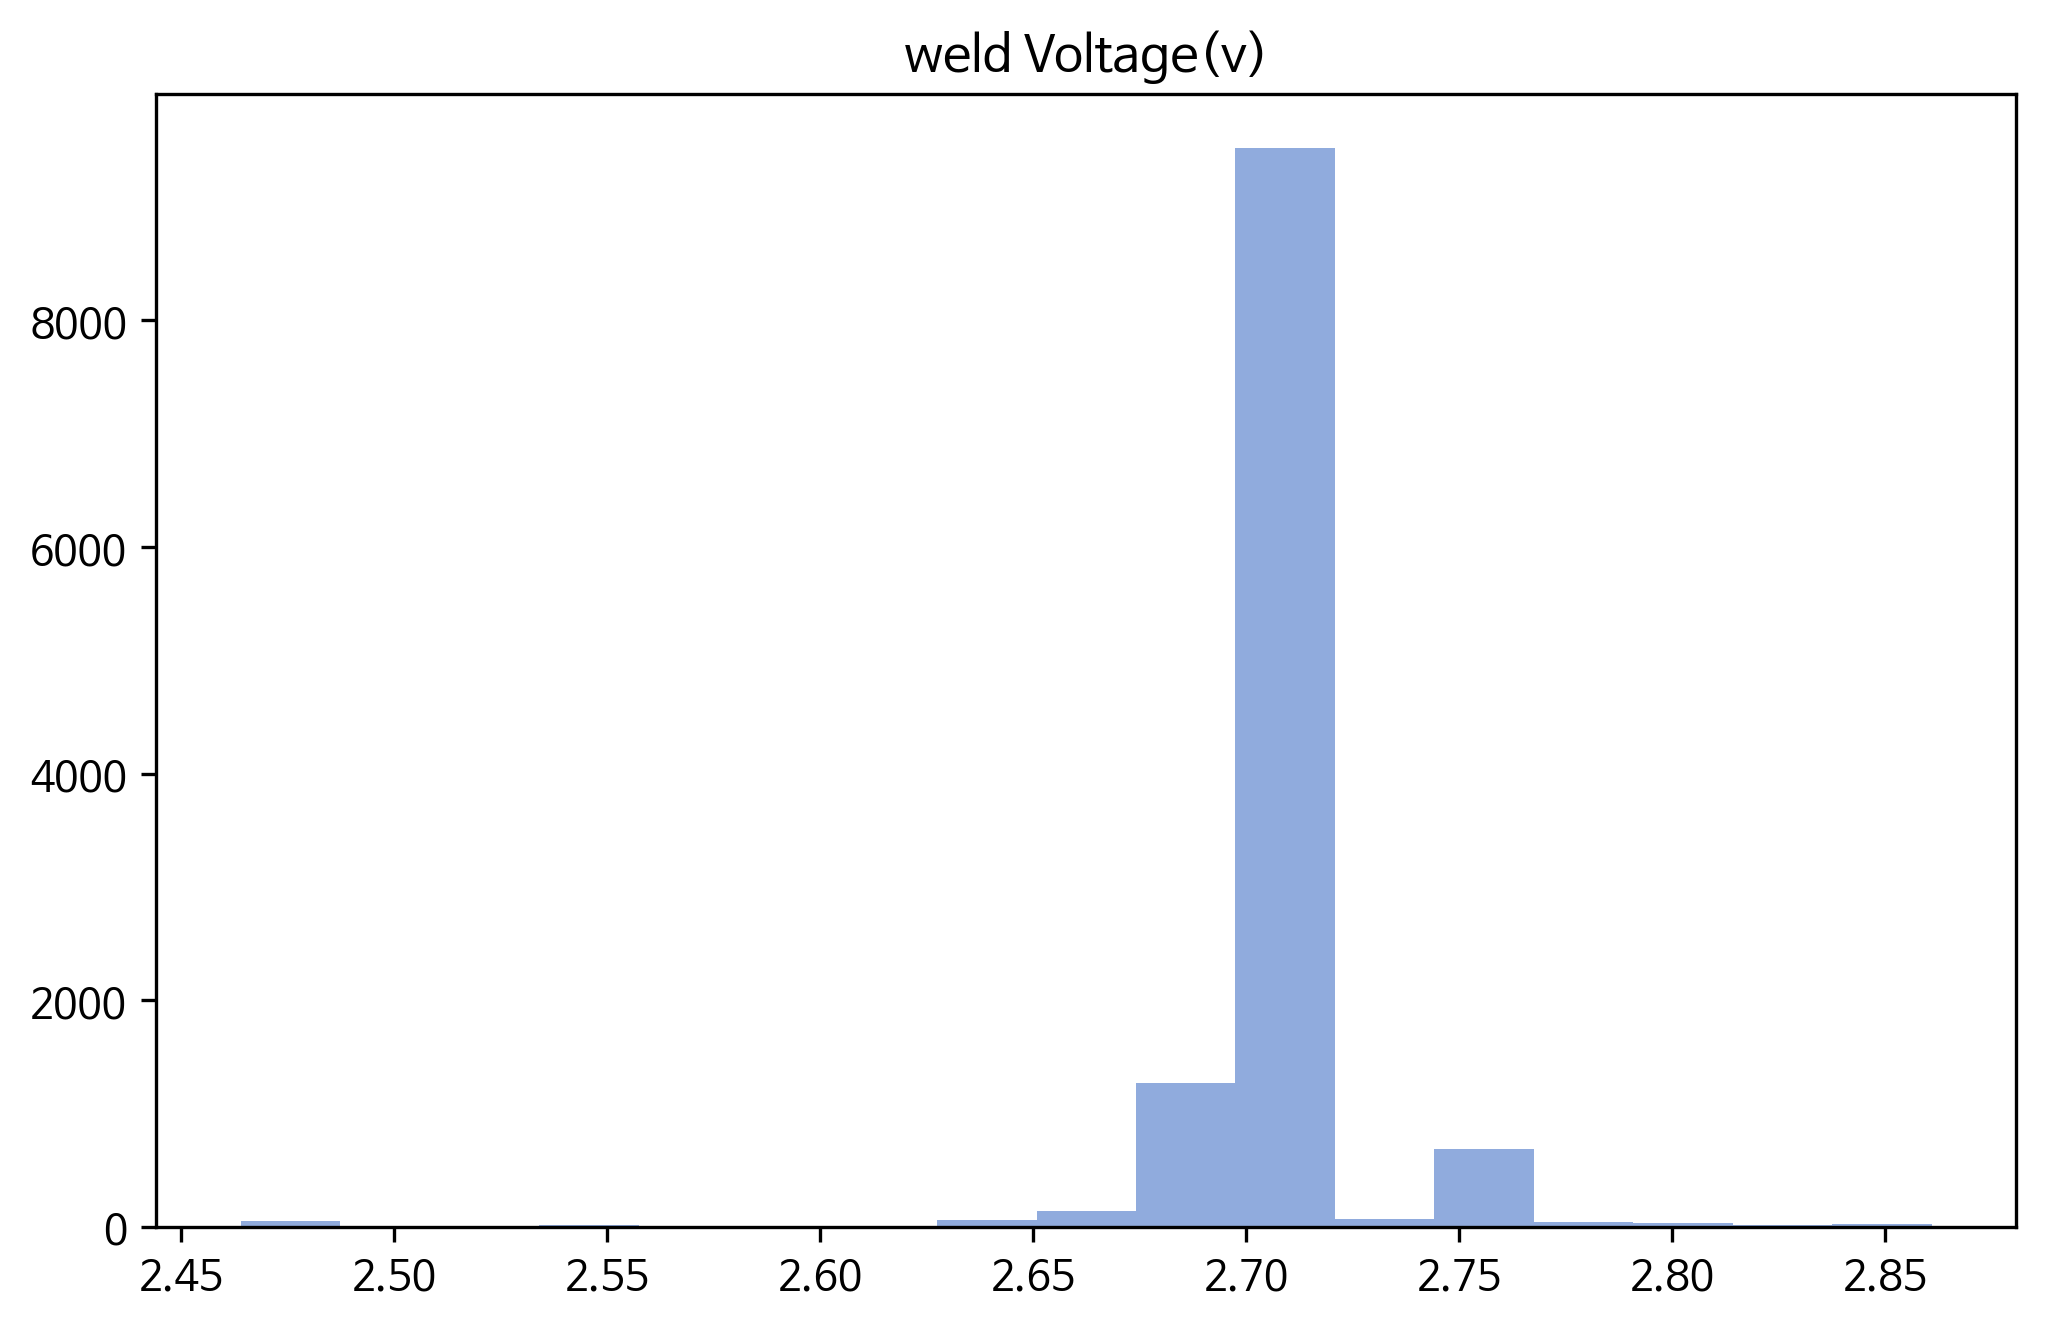

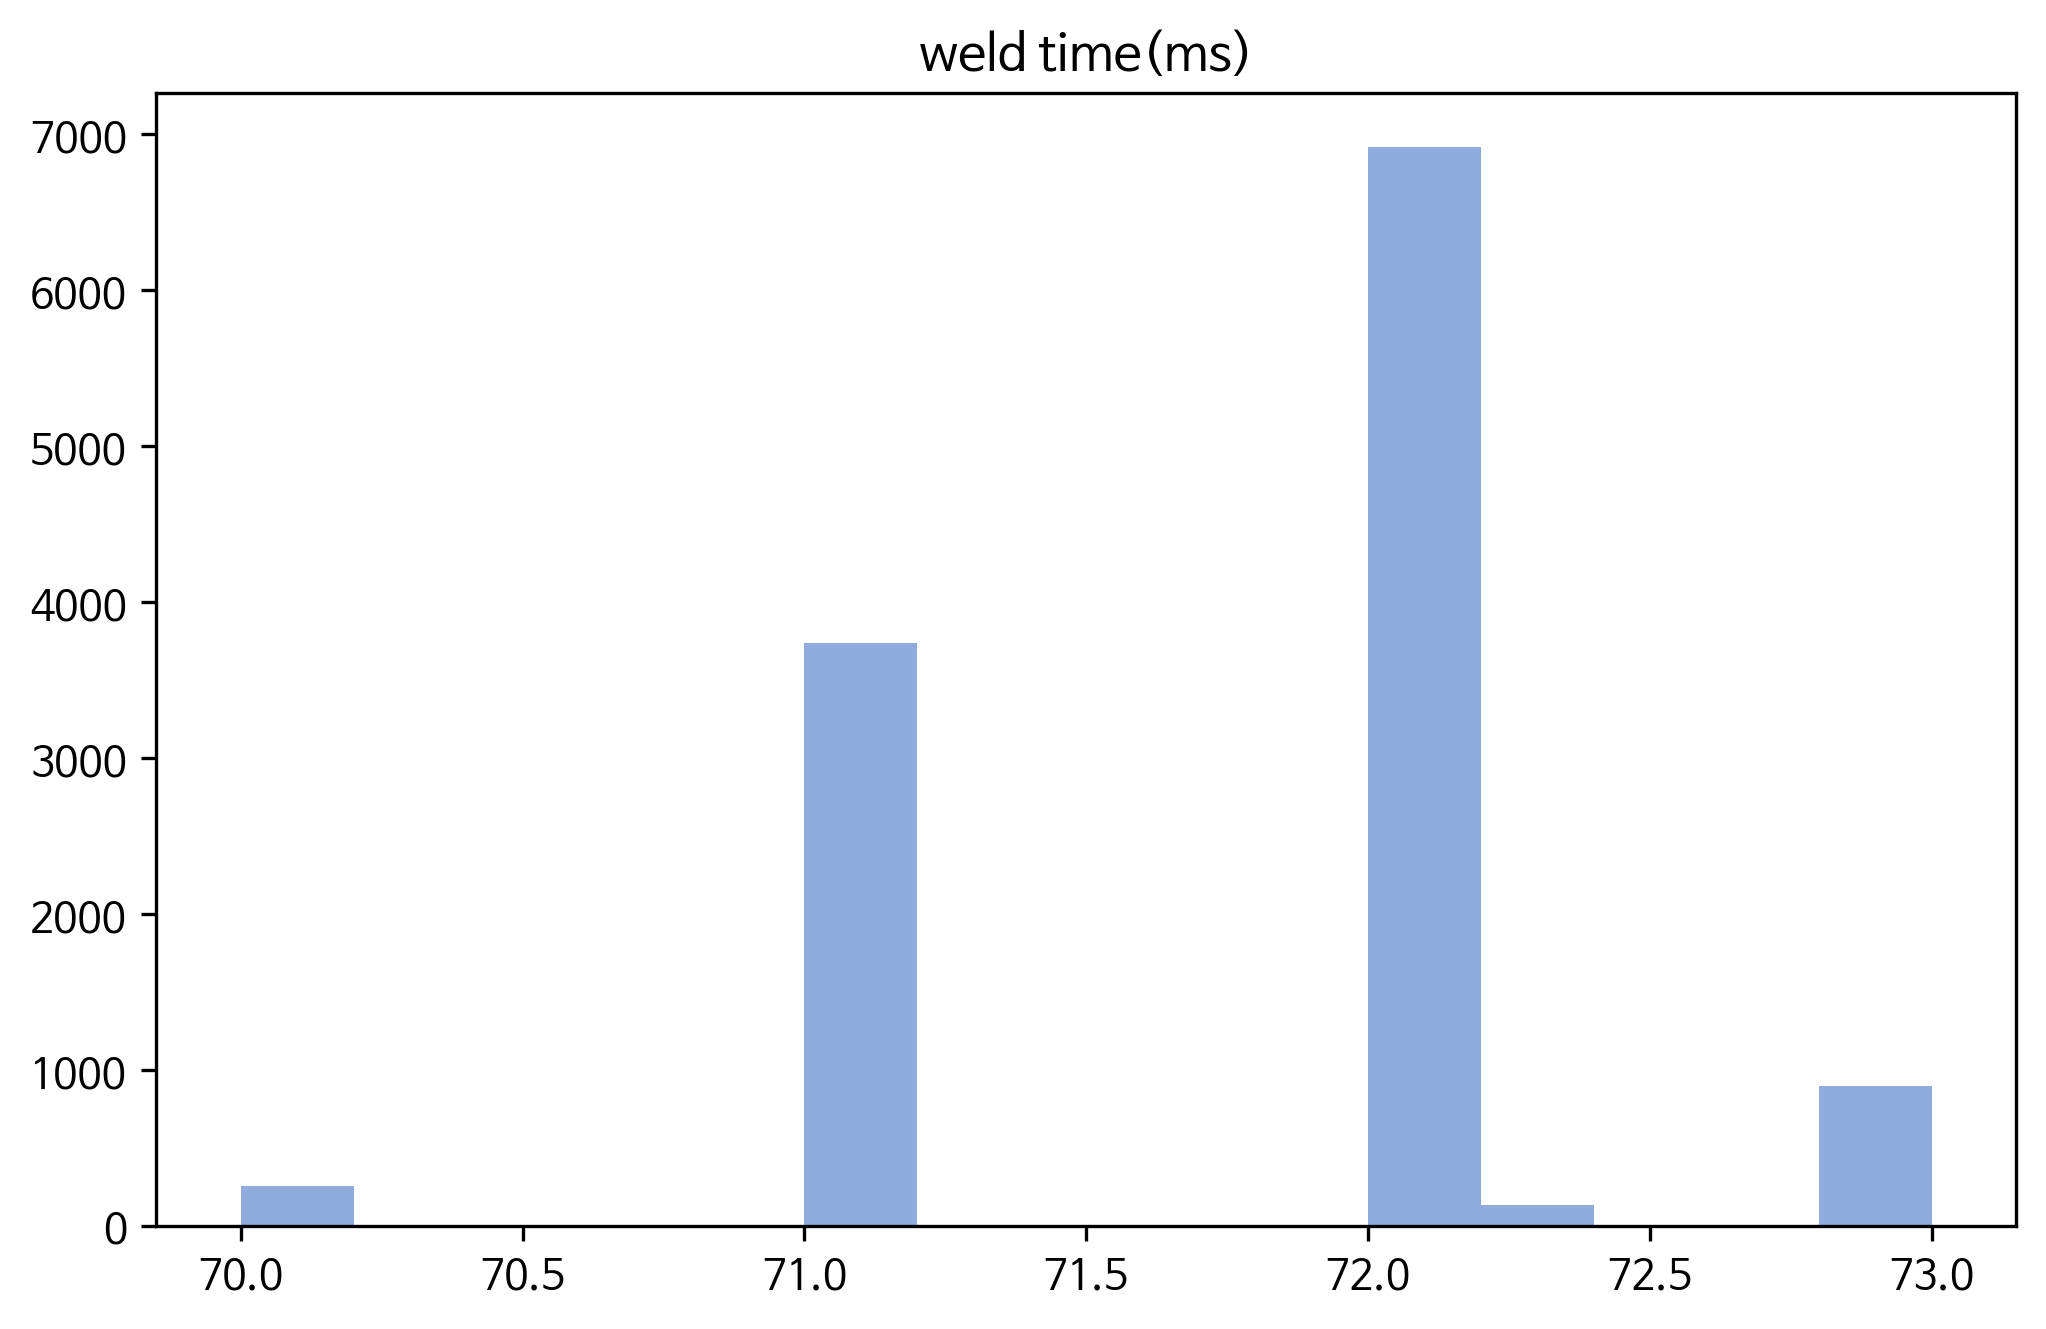

In [7]:
# histogram
bins_list = [15,15,15,15,15,25,13,17,15]
for index, value in enumerate(welding_data.columns):
    plt.figure(index)
    plt.hist(welding_data[value], bins = bins_list[index], facecolor = (144/255, 171/255, 221/255))
    plt.title(value)

## 전처리

In [8]:
# 학습에 사용하지 않을 column (Machine Name,생산품목, 작업시간, 소재두께1, 소재두께2) 제외
new_welding_data = welding_data.iloc[:, 5:]
new_welding_data.head()

,weld force(bar),weld current(kA),weld Voltage(v),weld time(ms)
idx,,,,
1,2.33,14.57,2.701,72.0
2,2.36,14.57,2.701,72.0
3,2.37,14.54,2.703,71.0
4,2.37,14.54,2.703,72.0
5,2.36,14.56,2.704,72.0


In [9]:
# 용접 가압력, 전류, 전압, 통전 시간의 단위가 다르므로 scaling
scaler = preprocessing.MinMaxScaler()
scaler.fit(new_welding_data)
scaled_data = scaler.transform(new_welding_data)

## 모델 학습

In [10]:
X_train, X_test = train_test_split(scaled_data, test_size=0.2, random_state=2021)

In [11]:
# 하이퍼 파라미터 정의
EPOCH = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.01
input_size = len(X_train[0]) # columns 개수 (용접 가압력, 전류, 전압, 통전시간)
hidden_size = 3
output_size =2

In [12]:
# 모델 구현
# encoder model
input_layer1 = layers.Input(shape=(input_size,))
x1 = layers.Dense(hidden_size, activation='relu')(input_layer1)
output_layer1 = layers.Dense(output_size, activation='relu')(x1)
encoder = Model(input_layer1, output_layer1)
# decoder model
input_layer2 = layers.Input(shape=(output_size,))
x2 = layers.Dense(hidden_size, activation='relu')(input_layer2)
output_layer2 = layers.Dense(input_size, activation='relu')(x2)
decoder = Model(input_layer2, output_layer2)
# AutoEncoder model
input_auto = layers.Input(shape=(input_size,))
output_auto = decoder(encoder(input_auto))
auto_encoder = Model(input_auto, output_auto)

2021-12-03 18:35:11.559455: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-03 18:35:11.559661: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# 모델 설정
auto_encoder.compile(loss='mean_squared_error', optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                     metrics=['mean_squared_error'])
Checkpoint = ModelCheckpoint(filepath="best_model.h5", verbose=1, save_best_only=True)
hist = auto_encoder.fit(X_train, X_train, epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True,
                    validation_data=(X_test, X_test), callbacks=[Checkpoint], verbose=1)

2021-12-03 18:35:11.664725: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
150/150 [==============================] - 1s 6ms/step - loss: 0.2330 - mean_squared_error: 0.2330 - val_loss: 0.2364 - val_mean_squared_error: 0.2364

Epoch 00001: val_loss improved from inf to 0.23642, saving model to best_model.h5
Epoch 2/50
150/150 [==============================] - 0s 1ms/step - loss: 0.2356 - mean_squared_error: 0.2356 - val_loss: 0.2364 - val_mean_squared_error: 0.2364

Epoch 00002: val_loss did not improve from 0.23642
Epoch 3/50
150/150 [==============================] - 0s 1ms/step - loss: 0.2351 - mean_squared_error: 0.2351 - val_loss: 0.2364 - val_mean_squared_error: 0.2364

Epoch 00003: val_loss did not improve from 0.23642
Epoch 4/50
150/150 [==============================] - 0s 869us/step - loss: 0.2345 - mean_squared_error: 0.2345 - val_loss: 0.2364 - val_mean_squared_error: 0.2364

Epoch 00004: val_loss did not improve from 0.23642
Epoch 5/50
150/150 [==============================] - 0s 895us/step - loss: 0.2335 - mean_squared_error: 0.2335

In [15]:
dir(welding_data)

['Machine_Name',
 'T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce_

In [16]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers.readers:

read_csv(filepath_or_buffer: 'FilePathOrBuffer', sep=<no_default>, delimiter=None, header='infer', names=<no_default>, index_col=None, usecols=None, squeeze=False, prefix=<no_default>, mangle_dupe_cols=True, dtype: 'DtypeArg | None' = None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, cache_dates=True, iterator=False, chunksize=None, compression='infer', thousands=None, decimal: 'str' = '.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, encoding_errors: 'str | None' = 'strict', dialect=None, error_bad_lines=None, warn_bad_lines=None, on_bad_lines=None, delim_whitespace=False, low_me

## 모델 예측 결과

In [14]:
## 훈련세트의 손실값 이용한 임계값 정의
# keras.losses.mean_squared_error(y_true, y_pred)